In [1]:
import math

import ConnectionNetworkX as cnx
import numpy as np
import networkx as nx
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm


matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


# Solving the Beckmann problem on a grid graph, i.e., pixel space.

Initialize the grid graph

In [2]:

GRID_WIDTH = 48
GRID_HEIGHT = 48
INTRINSIC_DIM = 3

gridGraph = cnx.cnxFromPixelGrid(GRID_WIDTH, GRID_HEIGHT, INTRINSIC_DIM)

gridGraphIncidenceMatrix = gridGraph.connectionIncidenceMatrix


Generate the constraint matrices and densities to be transported. Example seen here is dirac densities at corners of the grid.

In [3]:
import imageio

def localizedColorDensity(grid, centerInEmbeddingSpace, normalizedRGBValues, radiusInCanonicalEmbeddingSpace):

    RGB_DIM = 3

    x0, y0 = centerInEmbeddingSpace

    density = np.zeros((gridGraph.nNodes, RGB_DIM))#.flatten()[:,None]

    # In order for it to be a valid density we need to add some ambient color so the row sum is positive everywhere
    uniformNoise = (1 - normalizedRGBValues) / grid.nNodes

    for node in tqdm(grid.nodes):

        x, y = grid.gridEmbedding[node]

        d = ((x - x0) ** 2 + (y - y0) ** 2) ** 0.5

        if d <= radiusInCanonicalEmbeddingSpace:
            #alpha = math.exp(- math.log(4) * d / radiusInCanonicalEmbeddingSpace)
            alpha = 1 - d / radiusInCanonicalEmbeddingSpace
            scaledRGB = (alpha) * normalizedRGBValues
        else:
            scaledRGB = np.array([0, 0, 0])

        density[node, :] = scaledRGB + uniformNoise

    s = np.sum(density, axis=0)
    for dim in range(RGB_DIM):
        density[:, dim] /= s[dim]

    density = density.flatten()

    return density

def colorDensityFromImage(grid, path, RGB_DIM = 3):

    image = imageio.v3.imread(path) / 255
    density = np.zeros((gridGraph.nNodes, RGB_DIM))

    print("Processing image density ... ")

    for node in tqdm(grid.nodes):

        x, y = grid.gridEmbedding[node]
        i, j = min(math.floor(image.shape[0] * x), image.shape[0]-1), min(math.floor(image.shape[1] * y), image.shape[1] - 1)

        density[node, :] = image[i, j]

    s = np.sum(density, axis=0)
    for dim in range(RGB_DIM):
        density[:, dim] /= s[dim]

    density = density.flatten()

    return density

def renderColorDensityAsImage(grid, localizedColorDensity):

    fig, ax = plt.subplots()
    embedding = grid.gridEmbedding
    RGB_DIM = 3

    ax.set_xlim((0, 1 + 1/GRID_WIDTH))
    ax.set_ylim((0, 1 + 1/GRID_HEIGHT))

    for node in tqdm(list(range(gridGraph.nNodes))):

        INTENSITY = 1 / np.max(localizedColorDensity)

        center = embedding[node][0], embedding[node][1]
        colorRGB = (1 - INTENSITY*localizedColorDensity[(node * RGB_DIM) : ((node + 1) * RGB_DIM)]).tolist() + [1]

        nodeLabel = matplotlib.patches.Rectangle(center, 1/GRID_WIDTH, 1/GRID_HEIGHT, color=colorRGB)
        ax.add_patch(nodeLabel)

    plt.show()

Processing image density ... 


100%|██████████| 2304/2304 [00:04<00:00, 564.42it/s]


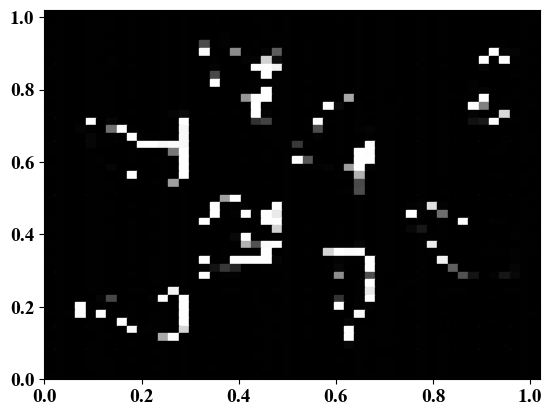

In [4]:
p = 'data/cat_test.jpg'

cat = colorDensityFromImage(gridGraph, p)

renderColorDensityAsImage(gridGraph, cat)

100%|██████████| 2304/2304 [00:03<00:00, 644.77it/s]


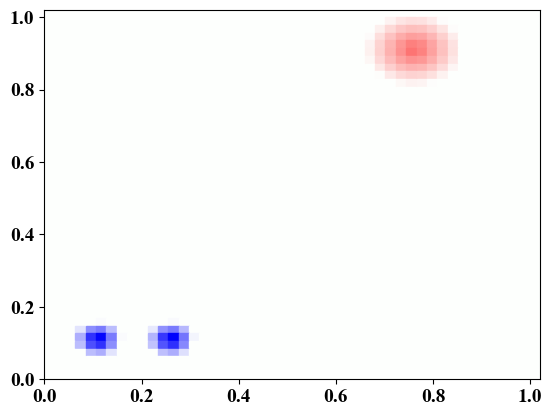

In [5]:
densityColorM = np.array([1, 1, 0])

m0 = localizedColorDensity(gridGraph, (0.1, 0.1), densityColorM, .05)
m1 = localizedColorDensity(gridGraph, (0.25, 0.1), densityColorM, .05)

m = 0.5 * (m0 + m1)

densityColorN = np.array([0, 1, 1])

n = localizedColorDensity(gridGraph, (0.75, 0.9), densityColorN, .1)

renderColorDensityAsImage(gridGraph, m + n)

In [ ]:
import torch
import time

t0 = time.time()

c = m - n
c.reshape((gridGraph.nNodes, INTRINSIC_DIM))
c = torch.tensor(c)

t1 = time.time()
print("time to init c: ", t1 - t0)

B = torch.tensor(gridGraphIncidenceMatrix.toarray())
w = torch.tensor(np.ones(B.T.shape[0]//INTRINSIC_DIM).astype('float32'))

t2 = time.time()
print("time to init B, w: ", t2 - t1)

#initialPhi = -np.matmul(np.linalg.pinv(np.matmul(B, B.T)), c)
initialPhi = -np.matmul(sp.linalg.pinvh(np.matmul(B, B.T)), c)

t3 = time.time()
print("time to init initPhi: ", t3-t2)

time to init c:  0.001352071762084961
time to init B, w:  2.757901906967163


In [ ]:
learning_rate = 0.1
alpha = 1
n_epochs = 1000

gridPhi = cnx.optimize(B.T, w, c, alpha, learning_rate, n_epochs, phi0=initialPhi)

# Visualizing the Soln. to the Connection Beckmann Problem on a Grid

In [ ]:
regularizedActiveEdges = cnx.active_edges(gridPhi, B.T, w, c).detach().numpy()
regularizedEdgeFlows = torch.matmul(B.T, gridPhi).detach().numpy()

spectralEmbedding = gridGraph.gridEmbedding

TOLERANCE = 0
MAX = np.max(regularizedActiveEdges)

fig, ax = plt.subplots()
ax.set_xlim((-.1, 1.1))
ax.set_ylim((-.1, 1.1))

for node in tqdm(list(range(gridGraph.nNodes))):
    center = spectralEmbedding[node][0], spectralEmbedding[node][1]
    # if node in [FROM_NODE_INDEX, TO_NODE_INDEX]:
    #     col="tab:red"
    #     zNode=4
    #     r=2e-2
    #      #ax.text(center[0], center[1], str(node+1))
    # else:
    # phi = gridPhi.detach().numpy()
    col = "tab:blue" # phi[(node * INTRINSIC_DIM) : ((node + 1) * INTRINSIC_DIM) ].tolist() + [1]  #"tab:blue"
    zNode=4
    r=1e-3
    nodeLabel = matplotlib.patches.Circle(center, radius=r, color=col, zorder=zNode)
    ax.add_patch(nodeLabel)

for edgeIndex, edge in zip(range(gridGraph.nEdges), list(gridGraph.edges())):

    flow = regularizedEdgeFlows[(edgeIndex * INTRINSIC_DIM) : ((edgeIndex + 1) * INTRINSIC_DIM) ]
    #col = gridPhi[(edge[0] * INTRINSIC_DIM) : ((edge[0] + 1) * INTRINSIC_DIM) ]

    flow = [1+x if x < 0 else 1 - x for x in flow] #1 + x

    if regularizedActiveEdges[edgeIndex] > TOLERANCE:
        alpha = abs(regularizedActiveEdges[edgeIndex])/MAX
        col= flow + [alpha] #(1, 0, .1, abs(regularizedActiveEdges[edgeIndex])/MAX)
        z = 3
        lw = 4
    else:
        #col="tab:blue"
        lw=0.5
        col=(1,1,1,0)
        z = 3

    fromNode = edge[0]
    toNode = edge[1]
    centerFromNode = spectralEmbedding[fromNode][0], spectralEmbedding[fromNode][1]
    centerToNode = spectralEmbedding[toNode][0], spectralEmbedding[toNode][1]

    ax.plot((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), color=col, lw=lw)

plt.show()

# xData, yData = spectralEmbedding.values
